In [3]:
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import IPython

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)

In [109]:
import scipy.io.wavfile
(rate, data) = scipy.io.wavfile.read('russian.wav')
# data = data[30000:200000,0]

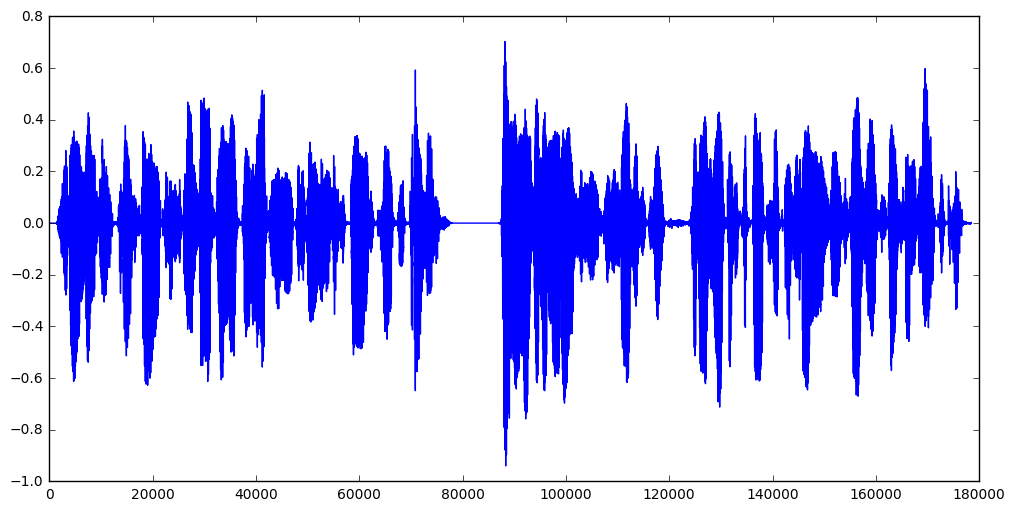

In [110]:
plt.plot(data)

In [111]:
IPython.display.Audio(data, rate=rate)

In [113]:
def stft(signal, window_size, hop_size):
    window = np.hanning(window_size + 2)[1:-1]
#     window = np.hanning(window_size)
    window /= sum(window)
    to_pad = hop_size - (len(signal) - window_size) % hop_size
    
    if to_pad < hop_size:
        signal = np.lib.pad(signal, (0, to_pad), 'constant', constant_values=0)
    
    return np.array([np.fft.fft(signal[i:i+window_size] * window)
                       for i in range(0, len(signal) - window_size, hop_size)])

In [114]:
def istft(data, window_size, hop_size):
    window = np.hanning(window_size + 2)[1:-1]
#     window = np.hanning(window_size)
    window /= sum(window)
    res = np.zeros(window_size + hop_size * data.shape[0])
    
    w_sum = np.zeros(len(res))
    for i in range(data.shape[0]):
        inverted = np.fft.ifft(data[i]).real
        res[i * hop_size : i * hop_size + window_size] += inverted * window
        w_sum[i * hop_size : i * hop_size + window_size] += window ** 2
        
    non_zero = w_sum != 0
    res[non_zero] /= w_sum[non_zero]
    
    return res

In [115]:
def spectrogram(signal, window_size, hop_size):
    return np.abs(stft(signal, window_size, hop_size)) ** 2

In [145]:
from IPython import display
import time

def ispectrogram(data, window_size, hop_size, iters=10, callback=None):
    res = np.random.random(window_size + hop_size * data.shape[0])
#     res = np.zeros(window_size + hop_size * data.shape[0])
    init_magnitudes = np.sqrt(data)
    
    reg = np.max(data) / 1e8
    
    max_diffs = []
    
    for i in range(iters):
        new_stft = stft(res, window_size, hop_size)
        new_stft = new_stft / np.maximum(reg, np.abs(new_stft))
        
        normalized_stft = init_magnitudes * new_stft
        res = istft(normalized_stft, window_size, hop_size)
        
        if callback != None:
            callback(res)
        
    return res

In [104]:
f0 = 440
f1 = 880
fs = rate
T = 5

t = np.linspace(0, T, T*fs, endpoint=False)
sine = np.hstack([np.sin(2*np.pi*f0*t), np.sin(2*np.pi*f1*t)])

IPython.display.Audio(sine, rate=rate)

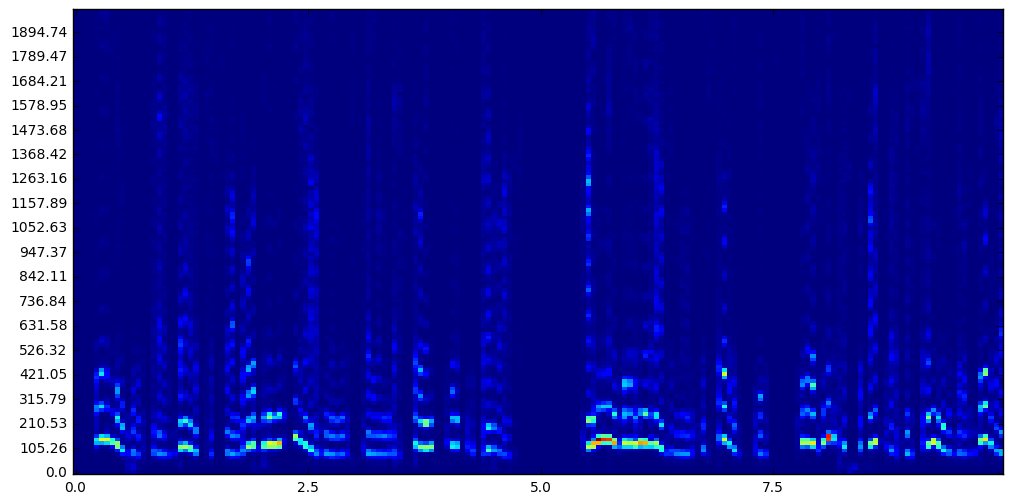

In [184]:
x = data

window_size = 1024
hop_size = 896
sample_rate = rate

min_freq = 0
min_freq_index = int(min_freq * window_size / sample_rate)
max_freq = 2000
max_freq_index = int(max_freq * window_size / sample_rate)
y_tick_count = 20

plt.yticks(np.linspace(0, max_freq_index - min_freq_index, y_tick_count), 
           np.round(np.linspace(min_freq, max_freq, y_tick_count), 2))

min_time = 0
min_time_index = int(min_time * sample_rate) / hop_size
max_time = 10
max_time_index = int(max_time * sample_rate) / hop_size
x_tick_count = 5

plt.xticks(np.linspace(0, max_time_index - min_time_index, x_tick_count), 
           np.round(np.linspace(min_time, max_time, x_tick_count), 2))

spec = spectrogram(x, window_size, hop_size)
# ispec = ispectrogram(spec, window_size, hop_size, iters=1)[:len(x)]

plt.imshow(np.sqrt(spec.T[min_freq_index:max_freq_index, min_time_index:max_time_index]), 
           origin='lower', aspect='auto', interpolation='nearest')

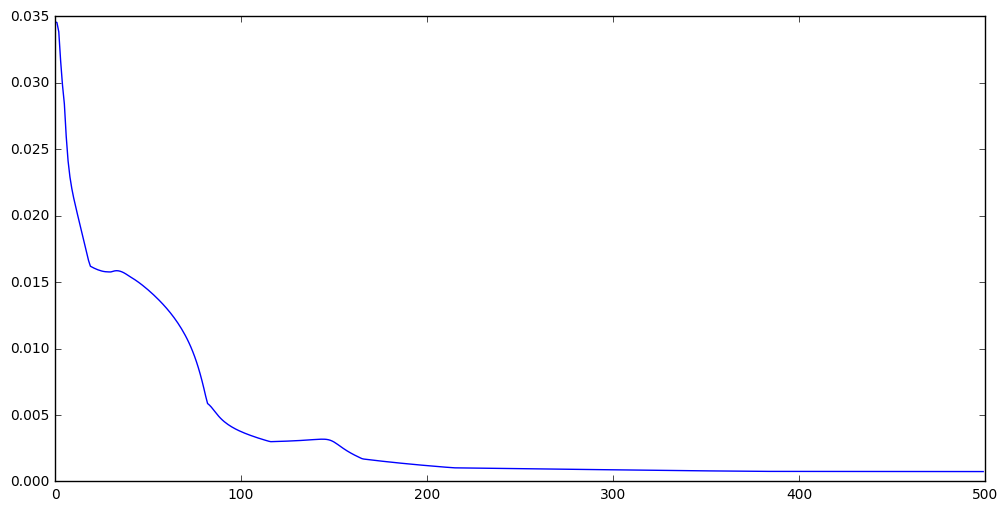

array([ 0.15088278,  0.01415855,  0.01350692, ...,  0.        ,
        0.        ,  0.        ])

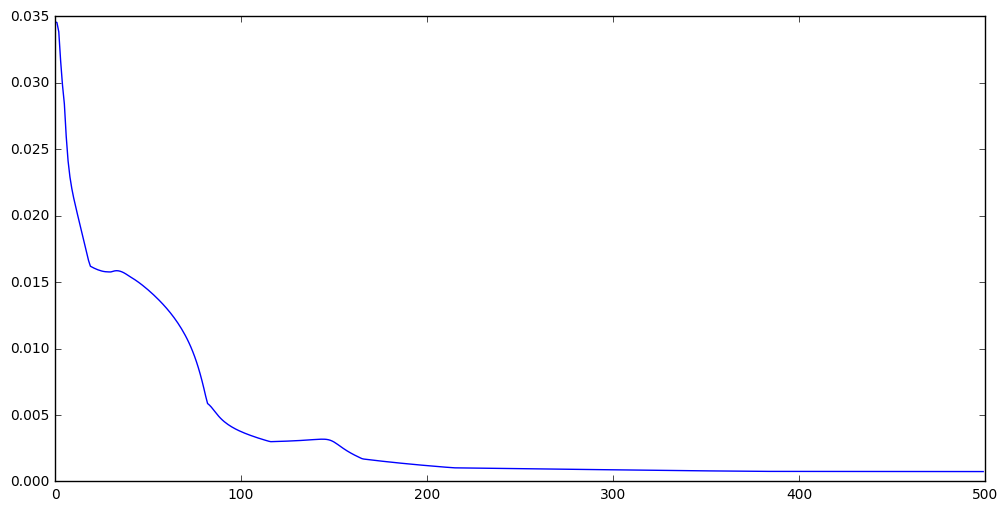

In [202]:
x = data

window_size = 1024
hop_size = 256
sample_rate = rate

spec = spectrogram(x, window_size, hop_size)

ispec = np.zeros(0)
max_diffs = []
spec_1 = np.zeros(0)

def ispec_callback(res):
    global ispec, spec_1
    global max_diffs
    
    ispec = res
    spec_1 = spectrogram(res, window_size, hop_size)
    max_diffs += [np.max(np.abs(spec_1 - spec))]
            
    plt.cla()
    plt.plot(max_diffs)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

ispectrogram(spec, window_size, hop_size, iters=500, callback=ispec_callback)[:len(x)]

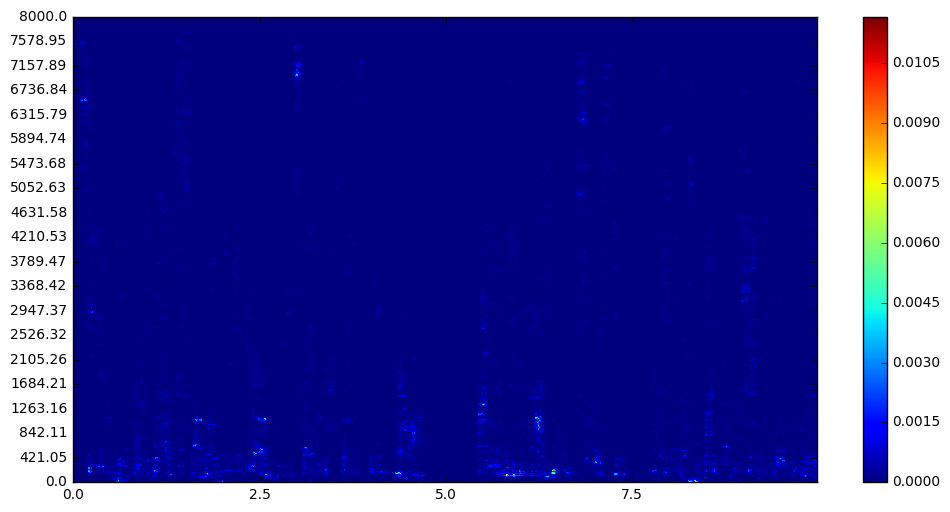

In [206]:
min_freq = 0
min_freq_index = int(min_freq * window_size / sample_rate)
max_freq = sample_rate / 2
max_freq_index = int(max_freq * window_size / sample_rate)
y_tick_count = 20

plt.yticks(np.linspace(0, max_freq_index - min_freq_index, y_tick_count), 
           np.round(np.linspace(min_freq, max_freq, y_tick_count), 2))

min_time = 0
min_time_index = int(min_time * sample_rate) / hop_size
max_time = 10
max_time_index = int(max_time * sample_rate) / hop_size
x_tick_count = 5

plt.xticks(np.linspace(0, max_time_index - min_time_index, x_tick_count), 
           np.round(np.linspace(min_time, max_time, x_tick_count), 2))


plt.imshow(np.abs(np.sqrt(spec.T[min_freq_index:max_freq_index, min_time_index:max_time_index]) - 
                  np.sqrt(spec_1.T[min_freq_index:max_freq_index, min_time_index:max_time_index])), 
           origin='lower', aspect='auto', interpolation='nearest')
plt.colorbar()

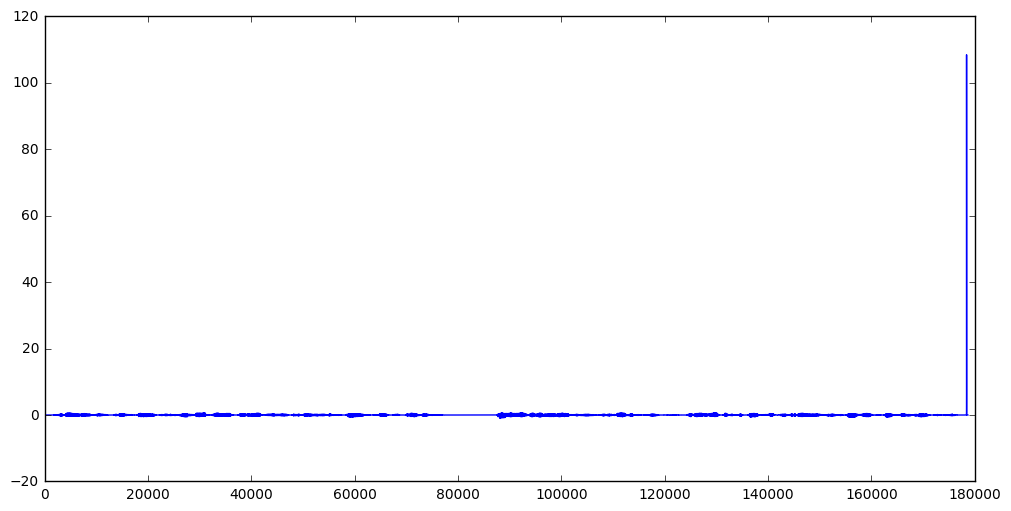

In [207]:
plt.plot(ispec)

In [208]:
IPython.display.Audio(np.clip(ispec, -1, 1), rate=rate)